# STA 663 Final Project: “The No-U-Turn Sampler”  

# Sarah Normoyle, Gonzalo Bustos  
# April 27, 2016  

## Table of Contents  
1. Introduction
2. Background
3. Implementation  
        a. Unoptimized Code
        b. Optimized Code
        c. Speed Up Ratios
4. Examples/Testing
        a. Poisson
        b. 5 dimensional MVN
        c. 10 dimensional MVN
5. Comparison
6. Conclusion
7. References 
        
 

## Introduction  



For many models, Monte Carlo Markov Chain (MCMC) methods such as Gibbs sampling and the Metropolis Hasting algorithm may not be efficient and may require a long time to converge. By using steps that are evaluated from the first-order gradient of the log posterior, Hamiltonian Monte Carlo (HMC) is an efficient MCMC algorithm that does not use random walk behavior. This paper by Matthew D. Hoffman and Andrew Gelman introduces a new algorithm, called the No-U-Turn Sampler (NUTS) that is an extension of Hamiltonian Monte Carlo. Unlike HMC, NUTS does not require the specification of the parameter for the number of steps, L. In addition, the use of a dual averaging technique is extended from HMC to NUTS in order to avoid the specification of a step size parameter, $\epsilon$. Therefore, unlike HMC, NUTS can be implemented without having to hand-tune both of the two parameters, L and $\epsilon$. In our report, we will implement the Naive NUTS Algorithm and also extend to the NUTS Algorithm with Dual Averaging. We will compare the efficiency and the results of this algorithm to other MCMC algorithms in Stan when used for a specific model and data set.

## Background

The performance of Hamiltonian Monte Carlo (HMC) depends strongly on choosing suitable values for $\varepsilon$ and $L$, which is the number of times chosen to run the leapfrog step. If $\varepsilon$ is too large, then the simulation will be inaccurate and yield low acceptance rates. If $\varepsilon$ is too small, then computation will be wasted taking many small steps. If $L$ is too small, then successive samples will be close to one another, resulting in undesirable random walk behavior and slow mixing. If $L$ is too large, then HMC will generate trajectories that loop back and retrace their steps.

The No-U-Turn Sampler (NUTS) is an extension of HMC that eliminates the need to specify a fixed value of $L$, the number of leapfrog steps. It also incorporates schemes for setting $\varepsilon$ based on a dual averaging algorithm.

Algorithm 1 from the paper goes through the Leapfrog function, which is also used in HMC. 

**Leapfrog step** from **Algorithm 1**

**function** Leapfrog$(\theta,r,\varepsilon)$

Set $\tilde{r} \leftarrow r + \frac{\varepsilon}{2} \nabla_\theta \mathcal{L}(\theta)$

Set $\tilde{\theta} \leftarrow \theta + \varepsilon \tilde{r}$

Set $\tilde{r} \leftarrow r + \frac{\varepsilon}{2} \nabla_\theta \mathcal{L}(\tilde{\theta})$

**return** $\tilde{\theta},\tilde{r}$

$\mathcal{L}$ is the logarithm of the joint density of the variables of interest $\theta$. The Leapfrog function of Algorithm 1 implements the Stormer-Verlet ("leapfrog") integrator, which proceeds according to the updates:

$r^{t + \frac{\varepsilon}{2}} = r^t + \frac{\varepsilon}{2} \nabla_\theta \mathcal{L}(\theta^t)$

$\theta^{t + \varepsilon} = \theta^t + \varepsilon r^{t + \frac{\varepsilon}{2}}$

$r^{t + \varepsilon} = r^{t + \frac{\varepsilon}{2}} + \frac{\varepsilon}{2} \nabla_\theta \mathcal{L}(\theta^{t + \varepsilon})$

where $r^t$ and $\theta^t$ denote the values of the momentum and position variables $r$ and $\theta$ at time $t$, $\nabla_\theta$ denotes the gradient with respect to $\theta$ and $\varepsilon$ is the step size parameter.

Before developing Algorithm 3, Efficient NUTS, the paper develops Algorithm 2, Naive NUTS. Algorithm 2 introduces a slice variable $u$ with conditional distribution $p(u|\theta,r)=\text{Uniform}(u;[0,\text{exp}\{\mathcal{L}(\theta) - \frac{1}{2} r \cdot r \}])$, which renders the conditional distribution $p(\theta,r|u) = \text{Uniform} (\theta,r;\{\theta',r'|\mathcal{L}(\theta) - \frac{1}{2} r \cdot r \} \geq u \})$. After resampling $u|\theta,r$, NUTS uses the leapfrog algorithm to trace out a path forwards and backwards, doing for 1 step, 2 steps, 4 steps, etc. This doubling process builds a balanced binary tree whose leaf-nodes correspond to position-momentum states. The process is halted when the trajectory starts to double back on itself. 

In summary, Algorithm 2 leaves the target distribution $p(\theta) \propto \text{exp}\{\mathcal{L}(\theta)\}$ invariant. It achieves this by resampling the momentum and slice variables $r$ and $u$, simulating a Hamiltonian trajectory forwards and backwards in time until that trajectory either begins retracing its steps or encounters a state with very low probability, selecting a subset of the states encountered on that trajectory that lie within the slice defined by the slice variable $u$, and finally choosing the next position and momentum variables $\theta^m$ and $r$ uniformly at random from the subset of the states encountered.

Algorithm 3 improves Algorithm 2 by breaking out of the recursion as soon as a zero value for the stop indicator $s$ is encountered.

Below is the first implementation of the NUTS sampler. It uses the Leapfrog function used in Hamiltonian Monte Carlo as well as a new BuildTree function. 

**Algorithm 3** Efficient NUTS

Given $\theta^0, \varepsilon, \mathcal{L}, M$:

**for** $m=1$ to $M$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Resample $r^0 \sim \mathcal{N}(0,I)$

&nbsp;&nbsp;&nbsp;&nbsp; Resample $u \sim \text{Uniform}([0, \text{exp}\{\mathcal{L}(\theta^{m-1}) - \frac{1}{2} r^0 \cdot r^0 \}])$

&nbsp;&nbsp;&nbsp;&nbsp; Initialize $\theta^- = \theta^{m-1},~\theta^+ = \theta^{m-1},~r^- = r^0,~r^+ = r^0,~j = 0,~\theta^m=\theta^{m-1},~n=1,~s=1$

&nbsp;&nbsp;&nbsp;&nbsp; **while** $s=1$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Choose a direction $v_j \sim \text{Uniform}(\{-1,1\})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $v_j=-1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,-,-,\theta',n',s' \leftarrow \text{BuildTree}(\theta^-,r^-,u,v_j,j,\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $-,-,\theta^+,r^+,\theta',n',s' \leftarrow \text{BuildTree}(\theta^+,r^+,u,v_j,j,\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $s'=1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; With probability $\text{min}\big\{1,\frac{n'}{n}\big\}$, set $\theta^m \leftarrow \theta'$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $n \leftarrow n + n'$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s \leftarrow s' \mathbb{1}[(\theta^+ - \theta^-) \cdot r^- \geq 0] \mathbb{1}[(\theta^+ - \theta^-) \cdot r^+ \geq 0]$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j \leftarrow j+1$

&nbsp;&nbsp;&nbsp;&nbsp; **end while**

**end for**
<br>
<br>
<br>
**function** BuildTree$(\theta,r,u,v,j,\varepsilon)$

**if** $j=0$ **then**

&nbsp;&nbsp;&nbsp;&nbsp; *Base case - take one leapfrog step in the direction $v$*

&nbsp;&nbsp;&nbsp;&nbsp; $\theta',r' \leftarrow \text{Leapfrog}(\theta,r,v\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp; $n' \leftarrow \mathbb{1}[u \leq \text{exp}\{\mathcal{L}(\theta') - \frac{1}{2} r' \cdot r' \}]$

&nbsp;&nbsp;&nbsp;&nbsp; $s' \leftarrow \mathbb{1}[\mathcal{L}(\theta') - \frac{1}{2} r' \cdot r' > \text{log}~u - \Delta_{max}]$

&nbsp;&nbsp;&nbsp;&nbsp; **return** $\theta',r',\theta',r',\theta',n',s'$

**else**

&nbsp;&nbsp;&nbsp;&nbsp; *Recursion - implicitly build the left and right subtrees*

&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,\theta^+,r^+,\theta',n',s' \leftarrow \text{BuildTree}(\theta,r,u,v,j-1,\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp; **if** $s'=1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $v=-1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,-,-,\theta'',n'',s'' \leftarrow \text{BuildTree}(\theta^-,r^-,u,v,j-1,\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $-,-,\theta^+,r^+,\theta'',n'',s'' \leftarrow \text{BuildTree}(\theta^+,r^+,u,v,j-1,\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; With probability $\frac{n''}{n'+n''}$, set $\theta' \leftarrow \theta''$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s' \leftarrow s'' \mathbb{1}[(\theta^+ - \theta^-) \cdot r^- \geq 0] \mathbb{1}[(\theta^+ - \theta^-) \cdot r^+ \geq 0]$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $n' \leftarrow n' + n''$

&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp; **return** $\theta^-,r^-,\theta^+,r^+,\theta',n',s'$

**end if**


Algorithm 6 further improves NUTS by adaptively tuning $\varepsilon$. In order to do this the paper uses the stichastic approximation method, using a statistic $H_t$ that describes some aspect of the behavior of an MCMC algorithm at iteration $t \geq 1$. The expectation of $H_t$ is defined as:

$h(x) = \mathbb{E}[H_t|x] = \lim_{T\to\infty}\frac{1}{T} \sum_{t=1}^T \mathbb{E}[H_t|x]$

$x \in \mathbb{R}$ is a tunable parameter to the MCMC algorithm. If $h$ is a non-decreasing function of $x$, the update $x_{t+1} \leftarrow x_t - \eta_t H_t$ is guaranteed to cause $h(x_t)$ to converge to 0, as long as the step size $\eta_t$ satisfies the following:

$\sum_t \eta_t = \infty$

$\sum_t \eta^2_t < \infty$

These conditions are satisfied for $\eta_t = t^{-\kappa}$, for $\kappa \in (0.5,1]$.

Adapting the dual averaging scheme, an algorithm for nonsmooth and stochastic convex optimization, to the problem of MCMC adaptation by replacing stochastic gradients with the statistic $H_t$, the updates are the following:

(i)$~~x_{t+1} \leftarrow \mu - \frac{\sqrt{t}}{\gamma} \frac{1}{t+t_0} \sum_{i=1}^t H_i$

(ii)$~~\bar{x}_{t+1} \leftarrow \eta_t x_{t+1} + (1 - \eta_t) \bar{x}_t$

Where $\mu$ is a chosen point to where the iterates $x_t$ are shrunk towards, $\gamma > 0$ is a parameter that controls the amount of shrinkage towards $\mu$, $t_0 \geq 0$ is a parameter that stabilizes the initial iterations and $\bar{x}_1 = x_1$. The paper uses te values $\gamma=0.05$, $t_0=10$ and $\kappa=0.75$, obtained by trying settings by hand on a model used as an example.

Eventhough, the dual averaging scheme should work for any initial value $\varepsilon_1$ and any shrinkage target $\mu$, the paper recommends choosing an initial value $\varepsilon_1$ according to the heuristic in Algorithm 4, which results in a value that is small enough to produce reasonably accurate simulations but large enough to avoid wasting large amounts of computation. The paper also recommends setting $\mu=log(10\varepsilon_1)$, in order to use larger values of $\varepsilon$ and save computation.

**Algorithm 4** Heuristic for choosing an initial values of $\varepsilon$

**function** FindReasonableEpsilon($\theta$)

Initialize $\varepsilon =1, r \sim \mathcal{N}(0,I)$  

Set $\theta', r' \leftarrow \text{Leapfrog}(\theta,r,\varepsilon)$

$a \leftarrow 2 \mathbb{1} \Big[\frac{p(\theta',r')}{p(\theta,r)} > 0.5\Big]  - 1$

**while** $\Big(\frac{p(\theta',r')}{p(\theta,r)}\Big)^a > 2^{-a}$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $\varepsilon \leftarrow 2^a \varepsilon$

&nbsp;&nbsp;&nbsp;&nbsp; Set $\theta', r' \leftarrow \text{Leapfrog}(\theta,r,\varepsilon)$

**end while**

**return** $\varepsilon$

In order to apply the dual averaging scheme for $\varepsilon$ it is necessary to define, for each iteration, the following statistic:

$H_t^{NUTS} = \frac{1}{|\mathcal{B}_t^{final}|} \sum_{\theta,r \in \mathcal{B}_t^{final}} \text{min}\Big\{1,\frac{p(\theta,r)}{p(\theta^{t-1},r^{t,0})} \Big\}$

$h^{NUTS} = \mathbb{E} [H_t^{NUTS}]$

$\mathcal{B}_t^{final}$ is the set of all the states explored during the final iteration $t$ of the Markov chain and $\theta^{t-1}$ and $r^{t,0}$ are the initial position and momentum for the $t^{th}$ iteration of the Markov chain. Assuming that $H^{NUTS}$ is non-increasing in $\varepsilon$, equations (i) and (ii) can be used with $H_t = \delta - H^{NUTS}$ and $x = \text{log}~\varepsilon$ to coerce $h^{NUTS} = \delta$ for any $\delta \in (0,1)$.

Algorithm 6 implements NUTS while incorporating the dual averaging algorithm, requiring a target mean acceptance probability $\delta$ and a number of iterations $M^{adapt}$.

**Algorithm 6** NUTS with Dual Averaging

Given $\theta^0, \delta, \mathcal{L}, M, M^{adapt}$:

Set $\varepsilon_0=\text{FindReasonableEpsilon}(\theta), \mu=\text{log}(10\varepsilon_0), \bar{\varepsilon}_0=1, \bar{H}=0, \gamma=0.05, t_0=10,\kappa=0.75$

**for** $m=1$ to $M$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Sample $r^0 \sim \mathcal{N}(0,I)$

&nbsp;&nbsp;&nbsp;&nbsp; Resample $u \sim \text{Uniform}([0, \text{exp}\{\mathcal{L}(\theta^{m-1}) - \frac{1}{2} r^0 \cdot r^0 \}])$

&nbsp;&nbsp;&nbsp;&nbsp; Initialize $\theta^- = \theta^{m-1},~\theta^+ = \theta^{m-1},~r^- = r^0,~r^+ = r^0,~j = 0,~\theta^m=\theta^{m-1},~n=1,~s=1$

&nbsp;&nbsp;&nbsp;&nbsp; **while** $s=1$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Choose a direction $v_j \sim \text{Uniform}(\{-1,1\})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $v_j=-1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,-,-,\theta',n',s',\alpha,n_\alpha \leftarrow \text{BuildTree}(\theta^-,r^-,u,v_j,j,\varepsilon_{m-1},\theta^{m-1},r^0)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $-,-,\theta^+,r^+,\theta',n',s',\alpha,n_\alpha \leftarrow \text{BuildTree}(\theta^+,r^+,u,v_j,j,\varepsilon_{m-1},\theta^{m-1},r^0)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $s'=1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; With probability $\text{min}\big\{1,\frac{n'}{n}\big\}$, set $\theta^m \leftarrow \theta'$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $n \leftarrow n + n'$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s \leftarrow s' \mathbb{1}[(\theta^+ - \theta^-) \cdot r^- \geq 0] \mathbb{1}[(\theta^+ - \theta^-) \cdot r^+ \geq 0]$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j \leftarrow j+1$

&nbsp;&nbsp;&nbsp;&nbsp; **end while**

&nbsp;&nbsp;&nbsp;&nbsp; **if** $m \leq M^{adapt}$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $\bar{H}_m = \Big(1 - \frac{1}{m+t_0} \Big) \bar{H}_{m-1} + \frac{1}{m+t_0} \Big( \delta + - \frac{\alpha}{n_\alpha} \Big)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $\text{log}~\varepsilon_m = \mu - \frac{\sqrt{m}}{\gamma} \bar{H}_m, \text{log}~\bar{\epsilon}_m = m^{-\kappa}~\text{log}~\varepsilon_m + (1 - m^{-\kappa})~\text{log}~\bar{\varepsilon}_{m-1}$

&nbsp;&nbsp;&nbsp;&nbsp; **else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $\varepsilon_m = \bar{\varepsilon}_{M^{adapt}}$

&nbsp;&nbsp;&nbsp;&nbsp; **end if**

**end for**
<br>
<br>
<br>
**function** BuildTree$(\theta,r,u,v,j,\varepsilon,\theta^0,r^0)$

**if** $j=0$ **then**

&nbsp;&nbsp;&nbsp;&nbsp; *Base case - take one leapfrog step in the direction $v$*

&nbsp;&nbsp;&nbsp;&nbsp; $\theta',r' \leftarrow \text{Leapfrog}(\theta,r,v\varepsilon)$

&nbsp;&nbsp;&nbsp;&nbsp; $n' \leftarrow \mathbb{1}[u \leq \text{exp}\{\mathcal{L}(\theta') - \frac{1}{2} r' \cdot r' \}]$

&nbsp;&nbsp;&nbsp;&nbsp; $s' \leftarrow \mathbb{1}[\mathcal{L}(\theta') - \frac{1}{2} r' \cdot r' > \text{log}~u - \Delta_{max}]$

&nbsp;&nbsp;&nbsp;&nbsp; **return** $\theta',r',\theta',r',\theta',n',s',\text{min}\{1,exp\{\mathcal{L}(\theta') - \frac{1}{2} r' \cdot r' - \mathcal{L}(\theta^0) + \frac{1}{2} r^0 \cdot r^0 \} \}, 1$ 

**else**

&nbsp;&nbsp;&nbsp;&nbsp; *Recursion - implicitly build the left and right subtrees*

&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,\theta^+,r^+,\theta',n',s',\alpha',n'_\alpha \leftarrow \text{BuildTree}(\theta,r,u,v,j-1,\varepsilon,\theta^0,r^0)$

&nbsp;&nbsp;&nbsp;&nbsp; **if** $s'=1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $v=-1$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta^-,r^-,-,-,\theta'',n'',s'',\alpha'',n''_\alpha \leftarrow \text{BuildTree}(\theta^-,r^-,u,v,j-1,\varepsilon,\theta^0,r^0)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $-,-,\theta^+,r^+,\theta'',n'',s'',\alpha'',n''_\alpha \leftarrow \text{BuildTree}(\theta^+,r^+,u,v,j-1,\varepsilon,\theta^0,r^0)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; With probability $\frac{n''}{n'+n''}$, set $\theta' \leftarrow \theta''$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s' \leftarrow s'' \mathbb{1}[(\theta^+ - \theta^-) \cdot r^- \geq 0] \mathbb{1}[(\theta^+ - \theta^-) \cdot r^+ \geq 0]$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $n' \leftarrow n' + n''$

&nbsp;&nbsp;&nbsp;&nbsp; **end if**

&nbsp;&nbsp;&nbsp;&nbsp; **return** $\theta^-,r^-,\theta^+,r^+,\theta',n',s',\alpha',n'_\alpha$

**end if**


## Implementation

We chose to implement Algorithm 6, the NUTS sampler with Dual Averaging adapted from Hamiltonian Monte Carlo because it does not require the specification of a value of epsilon. This algorithm requires 3 additional helper functions, FindReasonableEpsilon, BuildTree, and Leapfrog. Therefore, in total we implemented 4 algorithms.




## Unoptimized Code

In the first implementation, we followed the pseudocode pretty much exactly as follows above. This requires re-calculating the gradient many times in each of the helper functions. 

In [1]:
def Leapfrog_slow(theta, r, eps, L):
    """
    SUMMARY: 
    From Algorithm 1 in NUTS, Leapfrog step in Hamiltonian Monte Carlo/NUTS.
    Helper function for Algorithm 6. 
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    eps = step size
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
       
    OUTPUTS:
    theta_tilde = update theta vector
    
    r_tilde = updated r momenta vector
    """
    
    logp, grad = L(theta)
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde

In [2]:
def FindReasonableEpsilon_slow(theta, L):
    """
    SUMMARY:
    From Algorithm 4 in NUTS.
    Heuristic for choosing an initial value of epsilon.
    Helper function for Algorithm 6.
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    eps = value for initial value of epsilon, step size
    
    """
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime = Leapfrog_slow(theta, r, eps, L)
    
    logp, grad = L(theta)
    logp_prime, grad_prime = L(theta_prime)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime = Leapfrog_slow(theta, r, eps, L);
        logp_prime, grad_prime = L(theta_prime)
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [3]:
def BuildTree_slow(theta, r, u, v, j, eps, r_theta0, L):
    """
    SUMMARY:
    builds tree in NUTS sampler, helper function for Algorithm 6
    
    INPUTS:
    
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    v = direction in creating tree, value from -1 to 1
    
    j = height of tree, starts at 0
    
    eps = step size
    
    r_theta0 = joint probability of theta0 and r
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime
    
    """
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime = Leapfrog_slow(theta, r, v*eps, L)
        logp_prime, grad_prime = L(theta_prime)
        
        r_theta = logp_prime - 0.5 * np.dot(r_prime, r_prime)      

        n_prime = int(u <= np.exp(r_theta))   
        s_prime = int(r_theta > np.log(u) - 1000)
        alpha_prime = min(1, np.exp(r_theta - r_theta0))
                                                   
        return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree_slow(theta, r, u, v, j-1, eps, r_theta0, L)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, _,_, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree_slow(theta_minus, r_minus, u, v, j-1, eps, r_theta0, L)
            else:
                _, _, theta_plus, r_plus, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree_slow(theta_plus, r_plus, u, v, j-1, eps, r_theta0, L)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [4]:
def nuts6_dual_averaging_slow(theta0, M, M_adapt, L, delta = 0.6):
    """
    SUMMARY: 
    Not optimized version. 
    Implemented from Algorithm 6: NUTS with Dual Averaging.
    Needs helper functions BuildTree_slow, FindReasonableEpsilon_slow, and Leapfrog_slow.
    

    INPUTS:
    
    theta0 = initial values for values of parameters in model. len(theta0) = number of parameters
    
    M = number of samples desired
    
    M_adapt = the number of steps for the burn-in,
    also how long to run the dual averaging algorithm to find the appropriate epsilon
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    delta = target HMC acceptance probability.
    default value of 0.6
    is a value between 0 and 1
    
    
    OUTPUTS:
    
    samples = np.array matrix of samples of theta from algorithm
    dimensions of matrix are M x len(theta0)
    
    burned_in = same as samples matrix with burn_in samples removed
    dimensions of matrix are are M-M_adapt x len(theta0)
    
    """
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    eps = FindReasonableEpsilon_slow(theta0, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()
        logp, grad = L(samples[m-1,:])

        r_theta = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(r_theta), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0 
        
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree_slow(theta_minus, r_minus, u, v_j, j, eps, r_theta, L)
            else:
                _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree_slow(theta_plus, r_plus, u, v_j, j, eps, r_theta, L)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eps_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    
    return samples, burned_in

## Optimized Code

To optimize the code, we first tried jit from Numba to speed up the code. There was no speed ups determined, and we considered other options. 

Next, we made sure opportunities for vectorization were implemented, which they were in places that were needed. 

Next, we noticed that the log likelihood and the gradient had to be re-calculated for values of $\theta$ and $\theta'$ when being passed through various functions, such as Leapfrog and BuildTree. The more dimensions of $\theta$ we have, the longer re-calculating these values takes. Therfore, we can add the values of the log likelihood and the gradient as outputs and inputs for Leapfrom, BuildTree, and FindReasonableEpsilon. If the values of the log likelihood and gradient follows the value of $\theta$ throughout the algorithm, then we thought algorithm would speed up. We thus implemented new functions for each of the four functions. These functions ended up being faster. Their relative speeds is investigated with specific examples.

In [5]:
def Leapfrog(theta, r, grad, eps, L):
    """
    SUMMARY: 
    From Algorithm 1 in NUTS, Leapfrog step in Hamiltonian Monte Carlo/NUTS.
    Helper function for Algorithm 6. 
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    eps = step size
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
       
    OUTPUTS:
    theta_tilde = update theta vector
    
    r_tilde = updated r momenta vector
    """
    
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde, grad_tilde, logp_tilde

In [6]:
def FindReasonableEpsilon(theta, grad, logp, L):
    """
    SUMMARY:
    From Algorithm 4 in NUTS.
    Heuristic for choosing an initial value of epsilon.
    Helper function for Algorithm 6.
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    eps = value for initial value of epsilon, step size
    
    """
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L);
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [7]:
def BuildTree(theta, r, grad, u, v, j, eps, L, esto0):
    """
    SUMMARY:
    builds tree in NUTS sampler, helper function for Algorithm 6
    
    INPUTS:
    
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    v = direction in creating tree, value from -1 to 1
    
    j = height of tree, starts at 0
    
    eps = step size
    
    r_theta0 = joint probability of theta0 and r
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime
    
    """
    
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime, grad_prime, logp_prime = Leapfrog(theta, r, grad, v*eps, L)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)

        n_prime = int(u <= np.exp(esto))
        
        s_prime = int(esto > np.log(u) - 1000)

        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, grad_prime, theta_prime, r_prime, grad_prime, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, grad, u, v, j-1, eps, L, esto0)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, grad_minus, _,_,_, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, grad_minus, u, v, j-1, eps, L, esto0)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, grad_plus, u, v, j-1, eps, L, esto0)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
                grad_prime = grad_doub_prime
                logp_prime = logp_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [8]:
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    """
    SUMMARY: 
    Implemented from Algorithm 6: NUTS with Dual Averaging.
    Needs helper functions BuildTree, FindReasonableEpsilon, and Leapfrog.
    

    INPUTS:
    
    theta0 = initial values for values of parameters in model. len(theta0) = number of parameters
    
    M = number of samples desired
    
    M_adapt = the number of steps for the burn-in,
    also how long to run the dual averaging algorithm to find the appropriate epsilon
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    delta = target HMC acceptance probability.
    default value of 0.6
    is a value between 0 and 1
    
    
    OUTPUTS:
    
    samples = np.array matrix of samples of theta from algorithm
    dimensions of matrix are M x len(theta0)
    
    burned_in = same as samples matrix with burn_in samples removed
    dimensions of matrix are are M-M_adapt x len(theta0)
    
    """
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    logp, grad = L(theta0)
    eps = FindReasonableEpsilon(theta0, grad, logp, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0
        grad_minus = grad
        grad_plus = grad
        
        j = 0
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, grad_minus, _, _, _, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, grad_minus, u, v_j, j, eps, L, esto)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, grad_plus, u, v_j, j, eps, L, esto)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    logp = logp_prime
                    grad = grad_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
        
        eta = 1 / (m + t0)
        H_bar = (1 - eta)*H_bar + eta * (delta - alpha/n_alpha) 
        if m <= M_adapt:  
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eta = m**(-k)
            esp_bar = np.exp((1-eta) * np.log(eps_bar) + eta * np.log(eps))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    return samples, burned_in

After running examples (seen more in depth below), we calculated the speed up ratios for various examples.

The table of examples of speed up ratios is shown below. The examples are further explained below. 

With 5000 iterations of the algorithm and a data set of 100 observations, the times and the speed up ratios are shown below. The speed up ratios get higher as the model gets more complex.


|            | Slow         | Fast     | Speed-Up Ratio |
|------------|--------------|----------|----------------|
| Poisson    | 1.5 sec      | 1.04 sec | 1.44           |
| MVN (5-d)  | 2 min 39 sec | 34.5 sec | 4.61           |
| MVN (10-d) | 2 min 44 sec | 32.7 sec | 5.02           |

## Examples

In [9]:
# Set seed
np.random.seed(5)

### Simple Poisson Example

First, we tested the code with a simple Poisson example. We generated simulated data from a Poisson distribution, and then fit a Poisson model likelihood with an improper uniform prior. We ran the slow and the fast alogithm. The mean of the sampled $\theta's$ was very close to the mean of the data, so we considered this successful. 

In [10]:
# generate random poisson data
X_pois = np.random.poisson(5, 100)
def L_pois(theta):
    grad = sum(X_pois) / theta - 100
    logp = sum(X_pois)*np.log(theta) - theta*100
    return logp, grad

In [11]:
%%time
# run slow algorithm on poisson data
samples_pois, burned_in_pois_slow = nuts6_dual_averaging_slow(np.array([2]), 5000, 2000, L_pois)
print("The run time from the slow algorithm on the poisson data is:")

The run time from the slow algorithm on the poisson data is:
CPU times: user 1.49 s, sys: 16.1 ms, total: 1.51 s
Wall time: 1.5 s


In [12]:
%%time
# run fast on poisson data
samples_pois, burned_in_pois = nuts6_dual_averaging(np.array([2]), 5000, 2000, L_pois)
print("The run time from the fast algorithm on the poisson data is:")

The run time from the fast algorithm on the poisson data is:
CPU times: user 1.04 s, sys: 12.8 ms, total: 1.05 s
Wall time: 1.04 s


In [13]:
print("The mean of the data is:")
np.mean(X_pois)

The mean of the data is:


4.9699999999999998

In [14]:
print("The mean of the samples from the algorithm is:")
np.mean(burned_in_pois)

The mean of the samples from the algorithm is:


4.9855873668618411

### Multivariate Normal Examples

The next example we did was a multivariate normal.  We generated simulated data from a MVN distribution, and then fit a MVN model likelihood with an improper uniform prior. Once again, the mean of the sampled $\theta's$ was very close to the mean of the data, so we considered this successful. We ran both the slow and the fast implementations of the code on a 5 dimensional MVN and a 10 dimensional MVN. The data was generated with means of 1 and a covariance matrix that is the identity matrix, so there is no correlation between the different variables.

### MVN 5 dimensional

First we generate data from 5 dimensional MVN and create a function for the log likelihood and gradient. 

In [15]:
# simulate multivariate normal data
X_MVN5 = np.random.multivariate_normal(np.ones(5), np.identity(5), 100)

def L_MVN5(theta):
    cumsum = 0
    grad = 0
    for x in X_MVN5:
        cumsum += ((x - theta).T @ np.linalg.inv(np.identity(5))) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(np.identity(5)) 
    logp = -0.5 * cumsum
    return logp, grad

Running the 2 implementations of the algorithm below. 

In [16]:
%%time
# run for normal
samples, burned_in = nuts6_dual_averaging_slow(np.zeros(5), 5000, 1000, L_MVN5)
print("The run time from the slow algorithm on the MVN d-5 data is:")

The run time from the slow algorithm on the MVN d-5 data is:
CPU times: user 2min 37s, sys: 953 ms, total: 2min 38s
Wall time: 2min 39s


In [17]:
%%time
# run for MVN
samples_MVN5, burned_in_MVN5 = nuts6_dual_averaging(np.zeros(5), 5000, 1000, L_MVN5)
print("The run time from the fast algorithm on the MVN d-5 data is:")

The run time from the fast algorithm on the MVN d-5 data is:
CPU times: user 33.8 s, sys: 246 ms, total: 34 s
Wall time: 34.5 s


In [18]:
print("The mean vector of the data is:")
np.mean(X_MVN5, axis = 0)

The mean vector of the data is:


array([ 0.90158516,  0.97847045,  0.99262766,  1.01256208,  0.90676946])

In [19]:
print("The mean vector of the samples from the algorithm is:")
np.mean(burned_in_MVN5, axis = 0)

The mean vector of the samples from the algorithm is:


array([ 0.89403405,  0.98520147,  1.00344827,  1.00763917,  0.90151075])

We can see that the fast implementation of the algorithm was faster and that the algorithm outputed the means very accurately. 

### MVN 10 dimensional

First we generate data from 10 dimensional MVN and create a function for the log likelihood and gradient. 

In [20]:
# test speed up ratio for 10-d
# 10 dimensional multivariate normal data
X_MVN10 = np.random.multivariate_normal(np.ones(10), np.identity(10), 100)

def L_MVN10(theta):
    cumsum = 0
    grad = 0
    for x in X_MVN10:
        cumsum += ((x - theta).T @ np.linalg.inv(np.identity(10))) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(np.identity(10)) 
    logp = -0.5 * cumsum
    return logp, grad

Running the 2 implementations of the algorithm below. 

In [21]:
%%time
samples, burned_in = nuts6_dual_averaging_slow(np.zeros(10), 5000, 1000, L_MVN10)
print("The run time from the slow algorithm on the MVN d-10 data is:")

The run time from the slow algorithm on the MVN d-10 data is:
CPU times: user 2min 41s, sys: 1.22 s, total: 2min 43s
Wall time: 2min 44s


In [22]:
%%time
samples_MVN10, burned_in_MVN10 = nuts6_dual_averaging(np.zeros(10), 5000, 1000, L_MVN10)
print("The run time from the fast algorithm on the MVN d-25 data is:")

The run time from the fast algorithm on the MVN d-25 data is:
CPU times: user 32.6 s, sys: 98.2 ms, total: 32.7 s
Wall time: 32.7 s


In [23]:
print("The mean vector of the data is:")
np.mean(X_MVN10, axis = 0)

The mean vector of the data is:


array([ 1.12751441,  0.96174488,  0.92994176,  0.97605577,  0.9607406 ,
        1.06693436,  1.18451676,  0.92277773,  0.86999797,  1.13545702])

In [24]:
print("The mean vector of the samples from the algorithm is:")
np.mean(burned_in_MVN10, axis = 0)

The mean vector of the samples from the algorithm is:


array([ 1.12064651,  0.95581029,  0.93097548,  0.95586395,  0.97121095,
        1.06685188,  1.1759705 ,  0.92149073,  0.87795877,  1.11895955])

## Comparison with other MCMC Algorithm

To compare the implementation of NUTS with another MCMC algorithm, we test our algorithm against Metropolis by using pymc. We will use the 10 dimensional Multivariate Normal as our example here.

In [25]:
#pymc
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

niter = 5000
with pm.Model() as test_context:
    mu = pm.MvNormal('mu', 0, tau=np.identity(10), shape = 10)
    y = pm.MvNormal('y', mu=mu, tau= np.identity(10), observed = X_MVN10)
    step = pm.Metropolis()
    trace = pm.sample(niter,step=step)


 [-----------------100%-----------------] 5000 of 5000 complete in 0.7 sec

Below is getting the unique values to plot the path of accepted $\theta's$:

In [26]:
metropolis_samples = trace['mu']
# subset just accepted theta's
unique_samples_met = np.array([metropolis_samples[0,:]])

for i in range(1, niter):
    if all(metropolis_samples[i-1,:] != metropolis_samples[i,:]):
        unique_samples_met = np.vstack([unique_samples_met, metropolis_samples[i,:]])   

In [27]:
# subset just accepted theta's
unique_samples_MVN = np.array(samples_MVN10[0,:])
for i in range(1, 5000):
    if all(samples_MVN10[i-1,:] != samples_MVN10[i,:]):
        unique_samples_MVN = np.vstack([unique_samples_MVN, samples_MVN10[i,:]])
 

Plot of samples from NUTS sampler with path of first 50 accepted $\theta's$ plotted on top:

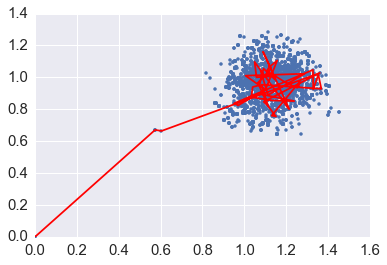

In [28]:
plt.plot(samples_MVN10[:,0], samples_MVN10[:,4], ".")
plt.plot(unique_samples_MVN[0:50,0], unique_samples_MVN[0:50,4], 'r')
pass


Plot of samples from Metropolis with path of first 50 accepted $\theta's$ plotted on top:

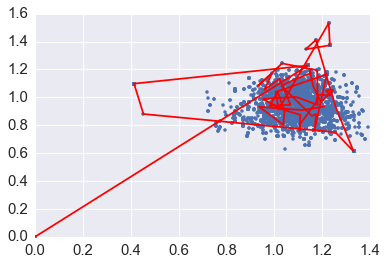

In [29]:
plt.plot(metropolis_samples[:,0], metropolis_samples[:,4], ".")
plt.plot(unique_samples_met[0:50,0], unique_samples_met[0:50,4], 'r')
pass

From looking at the plots above, we can see that both samples converged. The NUTS sampler converges to the center of the points more quickly and stayed around the convergence more quickly. This would be helpful when models get more complicated as this is a simple example. 

## Conclusion

NUTS with dual averaging makes it possible for Bayesian data analysts to obtain the efficiency of HMC without spending time and effort hand-tuning HMC's parameters, making it possible to efficiently perform Bayesian posterior inference on a large class of complex, high-dimesional models with minimal human intervention.  

We implemented the NUTS sampler in Python and were able to optimize our implementation of the NUTS sampler by removing the need to re-calculate the gradient and the log likelihood. We ran the NUTS sampler on various examples and compared them to another MCMC algorithm, Metropolis Hastings. 

The NUTS sampler appears to be overly complicated for simple examples, such as the ones we chose to show. However, it can very useful and efficient for higher order dimensional Bayesian MCMC problems.

## References

1. M. Hofmman and A. Gelman, "The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo", Journal of Machine Learning Research 15 (2014) 1351-1381

2. A. Gelman, J. Carlin, H. Stern, D. Dunson, A. Vehtari and D. Rubin, "Bayesian Data Analysis", Third Edition, CRC Press, 2014

3. S. Chibb and E. Greenberg, "Understanding the Metropolis-Hastings Algorithm", The American Statistician, November 1995, Vol. 49, No. 4

4. C. Robert and G. Casella, "A Short History of Markov Chain Monte Carlo: Subjective Recollections from Incomplete Data", Statistical Science, 2011, Vol. 26, No. 1, 102-115

5. C. Andrieu and J. Thoms, "A tutorial on adaptive MCMC", Stat Comput (2008) 18: 343–373